# Training RL Agent in Gridworld with SARSA method

## Imports

In [ ]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Gridworld

In [ ]:
class GridworldV2Env(gym.Env):
    def __init__(self, step_cost=-0.2, max_ep_length=500, explore_start=False):
        self.index_to_coordinate_map = {
            "0": [0, 0],
            "1": [0, 1],
            "2": [0, 2],
            "3": [0, 3],
            "4": [1, 0],
            "5": [1, 1],
            "6": [1, 2],
            "7": [1, 3],
            "8": [2, 0],
            "9": [2, 1],
            "10": [2, 2],
            "11": [2, 3],
        }
        self.coordinate_to_index_map = {
            str(val): int(key) for key, val in self.index_to_coordinate_map.items()
        }
        self.map = np.zeros((3, 4))
        self.observation_space = gym.spaces.Discrete(1)
        self.distinct_states = [str(i) for i in range(12)]
        self.goal_coordinate = [0, 3]
        self.bomb_coordinate = [1, 3]
        self.wall_coordinate = [1, 1]
        self.goal_state = self.coordinate_to_index_map[str(self.goal_coordinate)]  # 3
        self.bomb_state = self.coordinate_to_index_map[str(self.bomb_coordinate)]  # 7
        self.map[self.goal_coordinate[0]][self.goal_coordinate[1]] = 1
        self.map[self.bomb_coordinate[0]][self.bomb_coordinate[1]] = -1
        self.map[self.wall_coordinate[0]][self.wall_coordinate[1]] = 2

        self.exploring_starts = explore_start
        self.state = 8
        self.done = False
        self.max_ep_length = max_ep_length
        self.steps = 0
        self.step_cost = step_cost
        self.action_space = gym.spaces.Discrete(4)
        self.action_map = {"UP": 0, "RIGHT": 1, "DOWN": 2, "LEFT": 3}
        self.possible_actions = list(self.action_map.values())

    def reset(self):
        self.done = False
        self.steps = 0
        self.map = np.zeros((3, 4))
        self.map[self.goal_coordinate[0]][self.goal_coordinate[1]] = 1
        self.map[self.bomb_coordinate[0]][self.bomb_coordinate[1]] = -1
        self.map[self.wall_coordinate[0]][self.wall_coordinate[1]] = 2

        if self.exploring_starts:
            self.state = np.random.choice([0, 1, 2, 4, 6, 8, 9, 10, 11])
        else:
            self.state = 8
        return self.state

    def get_next_state(self, current_position, action):

        next_state = self.index_to_coordinate_map[str(current_position)].copy()

        if action == 0 and next_state[0] != 0 and next_state != [2, 1]:
            # Move up
            next_state[0] -= 1
        elif action == 1 and next_state[1] != 3 and next_state != [1, 0]:
            # Move right
            next_state[1] += 1
        elif action == 2 and next_state[0] != 2 and next_state != [0, 1]:
            # Move down
            next_state[0] += 1
        elif action == 3 and next_state[1] != 0 and next_state != [1, 2]:
            # Move left
            next_state[1] -= 1
        else:
            pass
        return self.coordinate_to_index_map[str(next_state)]

    def step(self, action):
        assert action in self.possible_actions, f"Invalid action:{action}"

        current_position = self.state
        next_state = self.get_next_state(current_position, action)

        self.steps += 1

        if next_state == self.goal_state:
            reward = 1
            self.done = True

        elif next_state == self.bomb_state:
            reward = -1
            self.done = True
        else:
            reward = self.step_cost

        if self.steps == self.max_ep_length:
            self.done = True

        self.state = next_state
        return next_state, reward, self.done

## Visualization function

In [ ]:
def plot_triangular(left, bottom, right, top, ax=None, triplotkw={}, tripcolorkw={}):

    if not ax:
        ax = plt.gca()
    n = left.shape[0]
    m = left.shape[1]

    a = np.array([[0, 0], [0, 1], [0.5, 0.5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])

    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))

    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5 : (k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4 : (k + 1) * 4, :] = tr + k * 5

    C = np.c_[
        left.flatten(), bottom.flatten(), right.flatten(), top.flatten()
    ].flatten()

    _ = ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

In [ ]:
def visualize_grid_action_values(grid_action_values):
    top = grid_action_values[:, 0].reshape((3, 4))
    top_value_positions = [
        (0.38, 0.25),
        (1.38, 0.25),
        (2.38, 0.25),
        (3.38, 0.25),
        (0.38, 1.25),
        (1.38, 1.25),
        (2.38, 1.25),
        (3.38, 1.25),
        (0.38, 2.25),
        (1.38, 2.25),
        (2.38, 2.25),
        (3.38, 2.25),
    ]
    right = grid_action_values[:, 1].reshape((3, 4))
    right_value_positions = [
        (0.65, 0.5),
        (1.65, 0.5),
        (2.65, 0.5),
        (3.65, 0.5),
        (0.65, 1.5),
        (1.65, 1.5),
        (2.65, 1.5),
        (3.65, 1.5),
        (0.65, 2.5),
        (1.65, 2.5),
        (2.65, 2.5),
        (3.65, 2.5),
    ]
    bottom = grid_action_values[:, 2].reshape((3, 4))
    bottom_value_positions = [
        (0.38, 0.8),
        (1.38, 0.8),
        (2.38, 0.8),
        (3.38, 0.8),
        (0.38, 1.8),
        (1.38, 1.8),
        (2.38, 1.8),
        (3.38, 1.8),
        (0.38, 2.8),
        (1.38, 2.8),
        (2.38, 2.8),
        (3.38, 2.8),
    ]
    left = grid_action_values[:, 3].reshape((3, 4))
    left_value_positions = [
        (0.05, 0.5),
        (1.05, 0.5),
        (2.05, 0.5),
        (3.05, 0.5),
        (0.05, 1.5),
        (1.05, 1.5),
        (2.05, 1.5),
        (3.05, 1.5),
        (0.05, 2.5),
        (1.05, 2.5),
        (2.05, 2.5),
        (3.05, 2.5),
    ]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_ylim(3, 0)
    tripcolor = plot_triangular(
        left,
        top,
        right,
        bottom,
        ax=ax,
        triplotkw={"color": "k", "lw": 1},
        tripcolorkw={"cmap": "rainbow_r"},
    )

    ax.margins(0)
    ax.set_aspect("equal")
    ax.set_axis_off()
    fig.colorbar(tripcolor)

    for i, (xi, yi) in enumerate(top_value_positions):
        plt.text(xi, yi, round(top.flatten()[i], 2), size=11, color="w")
    for i, (xi, yi) in enumerate(right_value_positions):
        plt.text(xi, yi, round(right.flatten()[i], 2), size=11, color="w")
    for i, (xi, yi) in enumerate(left_value_positions):
        plt.text(xi, yi, round(left.flatten()[i], 2), size=11, color="w")
    for i, (xi, yi) in enumerate(bottom_value_positions):
        plt.text(xi, yi, round(bottom.flatten()[i], 2), size=11, color="w")

    plt.show()

## SARSA method

In [ ]:
def sarsa(env, max_episodes):
    grid_action_values = np.zeros((len(env.distinct_states), env.action_space.n))
    grid_action_values[env.goal_state] = 1
    grid_action_values[env.bomb_state] = -1
    gamma = 0.99  # discounting factor
    alpha = 0.01  # learning rate
    # q: state-action-value function
    q = grid_action_values
    for episode in range(max_episodes):
        step_num = 1
        done = False
        state = env.reset()
        action = greedy_policy(q[state], 1)
        while not done:
            next_state, reward, done = env.step(action)
            step_num += 1
            decayed_epsilon = gamma ** step_num  # Doesn't have to be gamma
            next_action = greedy_policy(q[next_state], decayed_epsilon)
            q[state][action] += alpha * (
                reward + gamma * q[next_state][next_action] - q[state][action]
            )
            state = next_state
            action = next_action
    visualize_grid_action_values(grid_action_values)

In [ ]:
def greedy_policy(q_values, epsilon):
    """Epsilon-greedy policy """

    if random.random() >= epsilon:
        return np.argmax(q_values)
    else:
        return random.randint(0, 3)

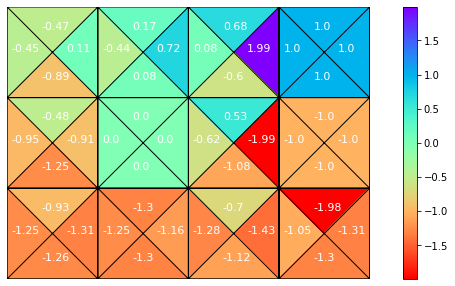

In [ ]:
if __name__ == "__main__":
    max_episodes = 4000
    env = GridworldV2Env(step_cost=-0.1, max_ep_length=30)
    sarsa(env, max_episodes)

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-02 11:26:24

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

gym       : 0.17.3
matplotlib: 3.2.2
numpy     : 1.19.5
seaborn   : 0.11.2
IPython   : 5.5.0



---

**END**